In [ ]:
import os, glob, pickle
import numpy as np
import matplotlib.pyplot as plt

: 

In [56]:
## make some job files for Ar
num_per_chunk = 1e7
nmc_zero_mass = 1e10
nmc_nonzero_mass = 1e8
num_reps_per_file = 100

iso = "ar_37"
mnu = 0

job_file = "/Users/dcmoore/grace/impulse/steriles/job_files/ar_37_jobs.txt"
jf = open(job_file, 'wt')
nchunks = int(nmc_zero_mass/(num_reps_per_file*num_per_chunk))
print(nchunks)
for i in range(nchunks):
    jf.write("module load miniconda; source activate; conda activate py37_dev; python calculate_pdfs.py %s %.1f %d %d\n"%(iso, mnu, num_reps_per_file, i))
jf.close()

# 100 reps and 1e7 per chunk is 1.5 gb and 15 minutes
# dsq --job-file job_files/ar_37_jobs.txt --mem-per-cpu 4g -t 30:00 --mail-type NONE


## now for non zero masses
job_file = "/Users/dcmoore/grace/impulse/steriles/job_files/ar_37_nonzero_jobs.txt"
jf = open(job_file, 'wt')
num_reps_per_file = int(nmc_nonzero_mass/num_per_chunk)
iso_dat = np.loadtxt("/Users/dcmoore/grace/impulse/steriles/data_files/%s.txt"%iso, delimiter=',', skiprows=3)
Q, t12, A = iso_dat[0, :]
## now as a function of sterile mass
mass_list = np.linspace(1, Q, 100)
nmasses_per_file = 5
nchunks = int(len(mass_list)/nmasses_per_file)
for i in range(nchunks):
    curr_masses = mass_list[(i*nmasses_per_file):((i+1)*nmasses_per_file)]
    curr_str = ["%.1f"%j for j in curr_masses]
    mnu = ','.join(curr_str)
    jf.write("module load miniconda; source activate; conda activate py37_dev; python calculate_pdfs.py %s %s %d %d\n"%(iso, mnu, num_reps_per_file, 0))
jf.close()

# 10 reps x 5 masses and 1e7 per chunk is 1.5 gb and 7.5 minutes
# dsq --job-file job_files/ar_37_nonzero_jobs.txt --mem-per-cpu 4g -t 30:00 --mail-type NONE


10


In [57]:
## collect and plot files from a given directory

data_dir = "/Users/dcmoore/grace/impulse/steriles/data_files/"
save_dir = "/Users/dcmoore/grace/impulse/steriles/pdfs/"
save_files = False

file_list = glob.glob(data_dir + "*.npz")

iso_list = []
## assumes file name starts with isotope in the form "el_A"
for f in file_list:
    cfile = os.path.split(f)[-1]
    fp = cfile.split('_')
    ciso = fp[0] + "_" + fp[1]
    if not ciso in iso_list:
        iso_list.append(ciso)

for iso in iso_list:

    curr_dict = {} ## dictionary to hold pdfs

    iso_files = glob.glob(data_dir + iso + "*.npz")

    ## make a list of the masses for that iso
    mnu_list = []
    for f in iso_files:
        cfile = os.path.split(f)[-1]
        fp = cfile.split('_')
        cmnu = fp[3]
        if not cmnu in mnu_list:
            mnu_list.append(cmnu)

    for mnu in mnu_list:

        curr_iso_files = glob.glob(data_dir + iso + "_mnu_" + mnu + "*.npz")
        nfiles = len(curr_iso_files)
        print("working on %d files for %s with mnu = %s: "%(nfiles, iso, mnu))

        for i in range(nfiles):
            pdf = np.load(curr_iso_files[i])
            
            if(i==0):
                p = pdf['pdf']
            else:
                p += pdf['pdf']

        x = pdf['x']

        cdf = np.cumsum(p)/np.sum(p)

        curr_dict[mnu] = np.vstack((x,p,cdf)).T

    if(save_files):
        of = open(save_dir + "%s_pdfs.pkl"%iso, "wb")
        pickle.dump(curr_dict, of)
        of.close()

working on 10 files for ar_37 with mnu = 0.0: 


OSError: [Errno 5] Input/output error

Exception ignored in: <function NpzFile.__del__ at 0x1114a3940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/numpy/lib/npyio.py", line 224, in __del__
    self.close()
  File "/usr/local/lib/python3.9/site-packages/numpy/lib/npyio.py", line 219, in close
    self.fid.close()
OSError: [Errno 5] Input/output error
Exception ignored in: <function NpzFile.__del__ at 0x1114a3940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/numpy/lib/npyio.py", line 224, in __del__
    self.close()
  File "/usr/local/lib/python3.9/site-packages/numpy/lib/npyio.py", line 219, in close
    self.fid.close()
OSError: [Errno 5] Input/output error


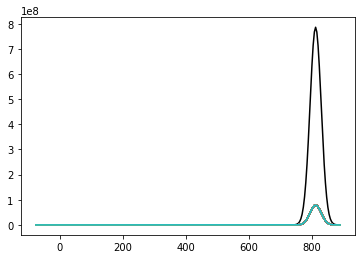

In [47]:
of = open(save_dir + '%s_pdfs.pkl'%iso, 'rb')
pdfs = pickle.load(of)
of.close()


mass_list_str = pdfs.keys()
mass_list = []
for m in mass_list_str:
  cmass = float(m)
  if(cmass > 0):
    mass_list.append(cmass)

mass_list = sorted(mass_list)

ulim = np.ones_like(mass_list)*1e6
bkg_pdf = pdfs['0.0']
plt.figure()
plt.semilogy(bkg_pdf[:,0], bkg_pdf[:,1], 'k')
for i,m in enumerate(mass_list):
  sig_pdf = pdfs['%.1f'%m]
  plt.semilogy(sig_pdf[:,0], sig_pdf[:,1])
